# Overview

In this notebook, we detail our Fourier filtering workflow and comparison to trained UNet models.

# Import Packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import h5py
from skimage.filters import gaussian
from skimage.filters import threshold_otsu

# Fourier filtering function

First, we create a function that takes an input image and outputs the inverse-FFT image given a certain bandpass filter

In [2]:
def fft_bandpass(img, r1, r2):
    #img is the image that needs to go through filtering
    #r1 is the inner radius of the bandpass filter (everything less than this will be masked)
    #r2 is the outer radius of the bandpass filter (everything greater than this will be masked)
    
    #First, create the circular masks
    total_rows, total_cols = img.shape
    X, Y = np.ogrid[:total_rows, :total_cols]
    center_row, center_col = total_rows/2, total_cols/2
    dist_from_center = (X - center_row)**2 + (Y - center_col)**2
    circular_mask_inner = (dist_from_center < r1**2)
    circular_mask_outer = (dist_from_center > r2**2)
    
    #Next, fft the image, shift such that the fft is circularly centered, and then apply the bandpass filter
    img_fft = np.fft.fft2(img)
    img_fft = np.fft.fftshift(img_fft)
    img_fft[circular_mask_inner] = 0
    img_fft[circular_mask_outer] = 0
    
    #Inverse fft the image
    ifft_image = np.fft.ifft2(img_fft)
    
    #Return the absolute value
    #return np.abs(ifft_image)
    return ifft_image

# Import non-augmented dataset

We will be using the dataset from Groschner et al. (2021), and specifically examine the test dataset. In order to make sure that it can also be used in the trained neural network, we will convert it into PyTorch format. 

In [3]:
def pyTorch_format(data_array):
    #Takes in a (N,H,W,C) numpy data array in float64 data type
    #Converts to a (N,C,H,W) numpy data array in float32 data type for PyTorch processing
    data_array = data_array.transpose((0,3,1,2))
    return np.float32(data_array)

In [4]:
#Import the dataset and labels
dataset = h5py.File('../../Dataset Creation/KateData/Au_Bal_MedFilt_cutimages_20190726.h5','r')['images']
labels = h5py.File('../../Dataset Creation/KateData/Au_Bal_unFilt_cutimages_20190423_maps.h5','r')['maps']

#Subset out the test dataset, which is the last 20% of the dataset
test_dataset = dataset[172:,:,:,:]
test_labels = labels[172:,:,:,1:]

test_dataset = pyTorch_format(test_dataset)
test_labels = pyTorch_format(test_labels)

print('Size of Test Set: ', test_dataset.shape)

Size of Test Set:  (44, 1, 512, 512)


# Fourier filter the non-augmented test dataset

In [6]:
ff_output = []
for i in range(test_dataset.shape[0]):
    # Compute Fourier Filter
    ifft_img = gaussian(np.abs(fft_bandpass(test_dataset[i,0,:,:], 38, 55)), sigma=9)
    o_threshold = threshold_otsu(ifft_img)
    ff_pred = (ifft_img>o_threshold).astype(float)
    ff_output.append(ff_pred)

Text(0.5, 1.0, 'Fourier Filtering')

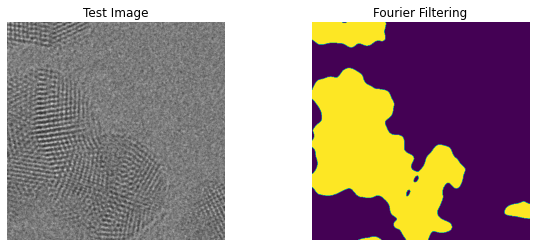

In [7]:
# Look at Fourier filtering results
sample_num = 7
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(test_dataset[sample_num,0,:,:],cmap='gray')
plt.axis('off')
plt.title('Test Image')
plt.subplot(1,2,2)
plt.imshow(ff_output[sample_num])
plt.axis('off')
plt.title('Fourier Filtering')

# Compare to UNet segmentation results

To compare, we will first load three trained 2-residual-block UNet models with different receptive fields: m22 (0.95nm receptive field), m44 (2.6nm receptive field), and m88 (8.4nm receptive field).

In [10]:
# First need to define all the model classes

class TEMImageDataset_Local(Dataset):
  """Creates a Dataset object that takes in local variables with all the training images"""

  def __init__(self, image_dataset, labels_dataset):
    """ Args:
      image_filepath (string): path to the h5 file with the images
      img_key (string): the "key" for the images in the h5 file
      labels_filepath (string): path to the h5 file with the maps/labels
      lbl_key (string): the "key" for the labels in the h5 file
    """
    self.image = image_dataset
    self.labels = labels_dataset
  
  def __len__(self):
    return self.image.shape[0]
  
  def __getitem__(self, idx):
    #If the provided idx is a tensor, then convert it to a list
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    images = self.image[idx] #Note that these output np arrays, not tensors
    labels = self.labels[idx]
    sample = {'image': images, 'label': labels}
    
    return sample

#Model classes
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size1, kernel_size2):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size1, padding=(kernel_size1-1)//2)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size2, padding=(kernel_size2-1)//2)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.conv_add = nn.Conv2d(in_channels,out_channels,kernel_size = 1) #Expands/contracts input image in the filter dimension for the ReLU skip connection

    #Copied from torchvision to correctly initialize layers
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    skip = self.conv_add(x)
    out += skip
    out = self.relu2(out)
    return out

class UNet_MaxPool(nn.Module): 
  def __init__(self, num_blocks, filter_sequence,pool_sequence, num_classes = 2):
    #num_blocks: number of residual blocks in network
    #filter_sequence: list of filter sizes
   
    super(UNet_MaxPool, self).__init__()
    self.down1 = ResidualBlock(1,filter_sequence[0],3,3)
    self.pool1 = nn.MaxPool2d(kernel_size = pool_sequence[0], stride = pool_sequence[0])

    self.down2 = ResidualBlock(filter_sequence[0],filter_sequence[1],3,3)
    self.pool2 = nn.MaxPool2d(kernel_size = pool_sequence[1], stride = pool_sequence[1])

    self.bottleneck = ResidualBlock(filter_sequence[1],filter_sequence[2],3,3)

    self.upsample2 = nn.Upsample(scale_factor=pool_sequence[1])
    self.up2 = ResidualBlock(filter_sequence[1]+filter_sequence[2],filter_sequence[1],3,3)

    self.upsample1 = nn.Upsample(scale_factor=pool_sequence[0])
    self.up1 = ResidualBlock(filter_sequence[0]+filter_sequence[1],filter_sequence[0],3,3)

    # final convolution with 1x1 kernel
    self.final_conv = nn.Conv2d(filter_sequence[0], num_classes, kernel_size = 1)

  
  def forward(self, x):
  
    skips = [] # empty array to store skip connections

    x = self.down1(x)
    skips.append(x)
    x = self.pool1(x)

    x = self.down2(x)
    skips.append(x)
    x = self.pool2(x)

    x = self.bottleneck(x)
    #skips = skips[::-1] # reverse skips array because we want to work with latest one first

    x = self.upsample2(x)
    skip = skips[1]
    concat_skip = torch.cat((skip,x),dim=1)
    x = self.up2(concat_skip)

    x = self.upsample1(x)
    skip = skips[0]
    concat_skip = torch.cat((skip,x),dim=1)
    x = self.up1(concat_skip)

    out = self.final_conv(x)

    return out

def test_loop(dataloader, model, loss_fn, optimizer, device):
  avg_loss = 0
  dice_score = 0
  hard_dice_score = 0
  size = len(dataloader.dataset)
  model.eval()
  with torch.no_grad():
    for batch_i, sample_batch in enumerate(dataloader):
      #Move the images and labels to the GPU
      images = sample_batch['image'].to(device)
      labels = sample_batch['label'].type(torch.LongTensor).to(device)
      #Compute the prediction (i.e. forward pass)
      pred = model(images)
      #Compute the loss
      loss = loss_fn(pred,labels[:,0,:,:]) 
      #Log the loss and dice score
      avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
      dice_score += compute_dice(pred, labels, device).item()
      hard_dice_score += compute_hard_dice(pred, labels, device).item()

  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice_score/size

def compute_dice(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = sm_layer(y_pred) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

def compute_hard_dice(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = torch.round(sm_layer(y_pred)) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

In [12]:
# Load models
save_directory = '../trained_models/'
hr_model22 = torch.load(save_directory+'20210922_UNet_b2_m22_run5_model.h5')
hr_model44 = torch.load(save_directory+'20210922_UNet_b2_m44_run5_model.h5')
hr_model88 = torch.load(save_directory+'20210922_UNet_b2_m88_run5_model.h5')

/home/ksytwu/anaconda3/envs/pytorch-1p9/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ksytwu/anaconda3/envs/pytorch-1p9/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ksytwu/anaconda3/envs/pytorch-1p9/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed

Setup the test dataloader and move all models to GPU

In [13]:
b_size = 32
test_datasetL = TEMImageDataset_Local(test_dataset,test_labels)
test_dataloader = DataLoader(test_datasetL, batch_size=b_size, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hr_model22.to(device)
hr_model44.to(device)
hr_model88.to(device);

Get the test set predictions with the three UNet models

In [14]:
pred22_list = []
pred44_list = []
pred88_list = []
with torch.no_grad():
    for batch_i, sample_batch in enumerate(test_dataloader):
      #Move the images and labels to the GPU
      images = sample_batch['image'].to(device)
      labels = sample_batch['label'].type(torch.LongTensor).to(device)
      #Compute the prediction (i.e. forward pass)
      pred22 = hr_model22(images)
      pred44 = hr_model44(images)
      pred88 = hr_model88(images)
      sm_layer = nn.Softmax2d()
      pred22 = sm_layer(pred22)
      pred44 = sm_layer(pred44)
      pred88 = sm_layer(pred88)  
      pred22_list.append(pred22)
      pred44_list.append(pred44)
      pred88_list.append(pred88)

/home/ksytwu/anaconda3/envs/pytorch-1p9/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Since there were two batches, we need to combine both into a single list

In [15]:
pred22_all = torch.cat((pred22_list[0],pred22_list[1]),0)
pred44_all = torch.cat((pred44_list[0],pred44_list[1]),0)
pred88_all = torch.cat((pred88_list[0],pred88_list[1]),0)

To compare UNet segmentation results against Fourier filtering, we will examine the missed nanoparticle regions and compute the dice similarity between the missed nanoparticle regions from the two methods.

In [16]:
def compute_dice_from_pred(pred, label, smooth=1):
    intersection = np.sum(pred*label)
    return (2. * intersection + smooth )/(np.sum(label) + np.sum(pred) + smooth)

In [17]:
miss_22_list = []
miss_44_list = []
miss_88_list = []
miss_ff_list = []
miss_dice22 = []
miss_dice44 = []
miss_dice88 = []


#For loop over each test image
for i in range(44):
    # Grab calculations
    gt = test_labels[i,0,:,:]
    predff = ff_output[i]
    pred22 = (pred22_all[i,1,:,:].detach().cpu().numpy()>0.5).astype(float)
    pred44 = (pred44_all[i,1,:,:].detach().cpu().numpy()>0.5).astype(float)
    pred88 = (pred88_all[i,1,:,:].detach().cpu().numpy()>0.5).astype(float)
    # Create maps of the nanoparticle regions that were missed
    miss_FF = (1-predff)*gt
    miss_22 = (1-pred22)*gt
    miss_44 = (1-pred44)*gt
    miss_88 = (1-pred88)*gt
    
    miss_22_list.append(miss_22)
    miss_44_list.append(miss_44)
    miss_88_list.append(miss_88)
    miss_ff_list.append(miss_FF)
    
    #Compute the similarity (via Dice score) of the missed particle regions
    miss_dice22.append(compute_dice_from_pred(miss_22, miss_FF))
    miss_dice44.append(compute_dice_from_pred(miss_44, miss_FF))
    miss_dice88.append(compute_dice_from_pred(miss_88, miss_FF))

We can now examine both the segmentation results and the missed particle regions

Text(0.5, 1.0, '8.4nm RF')

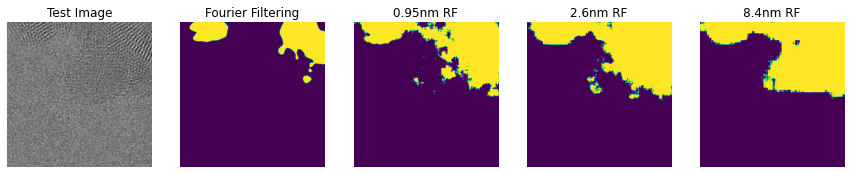

In [19]:
sample_num = 15
plt.figure(figsize=(15,7))
plt.subplot(1,5,1)
plt.imshow(test_dataset[sample_num,0,:,:],cmap='gray')
plt.axis('off')
plt.title('Test Image')
plt.subplot(1,5,2)
plt.imshow(ff_output[sample_num])
plt.axis('off')
plt.title('Fourier Filtering')
plt.subplot(1,5,3)
plt.imshow(pred22_all[sample_num,1,:,:].detach().cpu().numpy()>0.5)
plt.axis('off')
plt.title('0.95nm RF')
plt.subplot(1,5,4)
plt.imshow(pred44_all[sample_num,1,:,:].detach().cpu().numpy()>0.5)
plt.axis('off')
plt.title('2.6nm RF')
plt.subplot(1,5,5)
plt.imshow(pred88_all[sample_num,1,:,:].detach().cpu().numpy()>0.5)
plt.axis('off')
plt.title('8.4nm RF')

Text(0.5, 1.0, 'm88 missed areas')

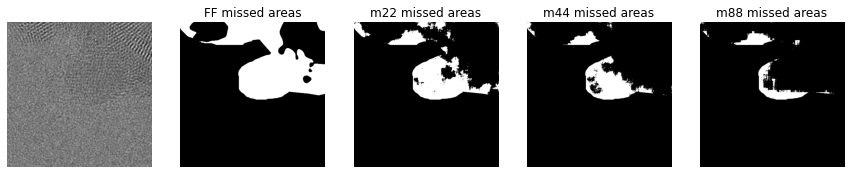

In [21]:
sample_num = 15
plt.figure(figsize=(15,7))
plt.subplot(1,5,1)
plt.imshow(test_dataset[sample_num,0,:,:],cmap='gray')
plt.axis('off')
plt.subplot(1,5,2)
plt.imshow(miss_ff_list[sample_num],cmap='gray')
plt.axis('off')
plt.title('FF missed areas')
plt.subplot(1,5,3)
plt.imshow(miss_22_list[sample_num],cmap='gray')
plt.axis('off')
plt.title('m22 missed areas')
plt.subplot(1,5,4)
plt.imshow(miss_44_list[sample_num],cmap='gray')
plt.axis('off')
plt.title('m44 missed areas')
plt.subplot(1,5,5)
plt.imshow(miss_88_list[sample_num],cmap='gray')
plt.axis('off')
plt.title('m88 missed areas')

In [22]:
print('m22 missed area Dice similarity to FF missed areas: ', miss_dice22[sample_num])
print('m44 missed area Dice similarity to FF missed areas: ', miss_dice44[sample_num])
print('m88 missed area Dice similarity to FF missed areas: ', miss_dice88[sample_num])

m22 missed area Dice similarity to FF missed areas:  0.686293182713779
m44 missed area Dice similarity to FF missed areas:  0.4816286752142161
m88 missed area Dice similarity to FF missed areas:  0.30706161271203186
